# 实验3 均值和中值滤波

## 一、导入图片

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random

Text(0.5, 1.0, 'lotus')

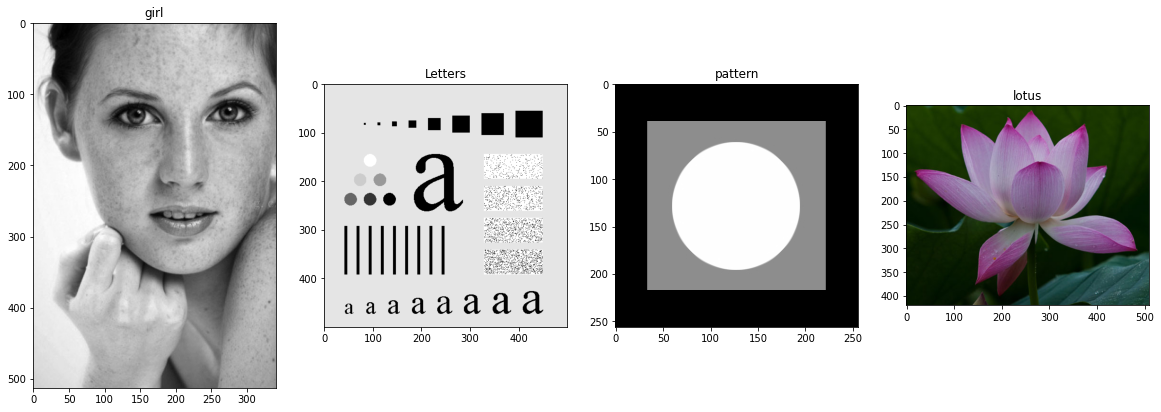

In [5]:
path = '.\Images\\Lab3\\'

girl = plt.imread(path+'girl.bmp')
Letters = plt.imread(path+'Letters-a.jpg')
pattern = plt.imread(path+'original_pattern.jpg')
lotus = plt.imread(path+'lotus.bmp')

plt.rcParams['figure.figsize'] = (20.0, 8.0) 
plt.subplot(1,4,1)
plt.imshow(girl, 'gray')
plt.title('girl')
plt.subplot(1,4,2)
plt.imshow(Letters, 'gray')
plt.title('Letters')
plt.subplot(1,4,3)
plt.imshow(pattern, 'gray')
plt.title('pattern')
plt.subplot(1,4,4)
plt.imshow(lotus, 'gray')
plt.title('lotus')

## 二、定义方法类

In [6]:
class Conv2D():
    #支持批量处理多通道的图像，同时支持多卷积核操作，支持Pooling操作
    #*********Padding**********#
    def __zero_pad(X, pad, value=0):
        X_pad = np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)), 'constant', constant_values = (value,value))
        # batch维度不填充，长宽同宽填充，通道不填充，填充值为0
        return X_pad
    
    #**********conv***********#
    def __conv_single_step(image_slice, W):
        s = np.multiply(image_slice, W)
        Z = np.sum(s)

        return Z

    def __conv_steps(images, pad, stride, filter):
        (batch, height, width, inchannels_num) = images.shape
        (f_h, f_w, _, outchannels_num) = filter.shape
        n_H = int((height-f_h+2*pad)/stride)+1
        n_W = int((width-f_w+2*pad)/stride)+1

        Z = np.zeros((batch, n_H, n_W, outchannels_num))

        images_pad = Conv2D.__zero_pad(images, pad)
        
        for i in range(batch):
            image_pad = images_pad[i]
            for h in range(n_H):
                for w in range(n_W):
                    for c in range(outchannels_num):
                        vert_start = h*stride
                        vert_end = vert_start+f_h
                        horiz_start = w*stride
                        horiz_end = horiz_start+f_w
                        image_slice = image_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                        Z[i, h, w, c] = Conv2D.__conv_single_step(image_slice, filter[:,:,:,c])
        return Z     

    def __conv_forward(images, filter, Isbatch=0, stride=1, pad=0):
        inDimension = len(images.shape)
        outDimension = len(filter.shape)

        if(inDimension==4): #多通道图像的批量处理
            (batch, height, width, inchannels_num) = images.shape
            if(outDimension==4):
                (f_h, f_w, _, outchannels_num) = filter.shape
            elif(outDimension==3):
                (f_h, f_w, _) = filter.shape
                outchannels_num = 1
                filter = np.expand_dims(filter, axis=-1)
            else:
                raise Exception('The filter must have the same number of channels as input image!')
            return Conv2D.__conv_steps(images, pad, stride, filter)
                
        elif(inDimension==3):
            if(Isbatch): #灰度图像的批量处理
                (batch, height, width) = images.shape
                inchannels_num = 1
                images = np.expand_dims(images, axis=-1)
                if(outDimension==3):
                    (f_h, f_w, outchannels_num) = filter.shape
                    filter = np.expand_dims(filter, axis=2)
                elif(outDimension==2):
                    (f_h, f_w) = filter.shape
                    outchannels_num = 1
                    filter = np.expand_dims(filter, axis=-1)
                    filter = np.expand_dims(filter, axis=-1)
                else:
                    raise Exception('The filter must have the same dimension as input image!')
                return Conv2D.__conv_steps(images, pad, stride, filter)[:,:,:,0]

            else: #单个样本的多通道图像处理
                (height, width, inchannels_num) = images.shape
                batch = 1
                images = np.expand_dims(images, axis=0)
                if(outDimension==4):
                    (f_h, f_w, _, outchannels_num) = filter.shape
                elif(outDimension==3):
                    (f_h, f_w, _) = filter.shape
                    outchannels_num = 1
                    filter = np.expand_dims(filter, axis=-1)
                else:
                    raise Exception('The filter must have the same number of channels as input image!')
                return Conv2D.__conv_steps(images, pad, stride, filter)[0,:,:,:]

        elif(inDimension==2): #单张灰度图像的处理
            (height, width) = images.shape
            images = np.expand_dims(images, axis=0)
            images = np.expand_dims(images, axis=-1)
            inchannels_num = 1; batch = 1
            if(outDimension==3):
                (f_h, f_w, outchannels_num) = filter.shape
                filter = np.expand_dims(filter, axis=2)
            elif(outDimension==2):
                (f_h, f_w) = filter.shape
                outchannels_num = 1
                filter = np.expand_dims(filter, axis=-1)
                filter = np.expand_dims(filter, axis=-1)
            else:
                raise Exception('The filter must have the same dimension as input image!')
            return Conv2D.__conv_steps(images, pad, stride, filter)[0,:,:,0]

        else:
            raise Exception("Dimension Error!")
            return 

    #**********Pooling**********#
    def __pool_steps(images, pad, stride, f, oper='mean'):
        (batch, height, width, inchannels_num) = images.shape
        n_H = int((height-f+2*pad)/stride)+1
        n_W = int((width-f+2*pad)/stride)+1

        Z = np.zeros((batch, n_H, n_W, inchannels_num), dtype=np.uint8)

        images_pad = Conv2D.__zero_pad(images, pad)

        for i in range(batch):
            image_pad = images_pad[i]
            for h in range(n_H):
                for w in range(n_W):
                        vert_start = h*stride
                        vert_end = vert_start+f
                        horiz_start = w*stride
                        horiz_end = horiz_start+f
                        image_slice = image_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                        if(oper=='mean'):
                            Z[i, h, w, :] = np.around(np.mean(image_slice, axis=(0,1)))
                        elif(oper=='median'):
                            Z[i, h, w, :] = np.around(np.median(image_slice, axis=[0,1]))
                        elif(oper=='max'): 
                            Z[i, h, w, :] = np.around(np.max(image_slice, axis=(0,1)))
                        else:
                            raise Exception('Please Enter fiterType as \'mean\' or \'median\' or \'max\'')

        return Z

    def __pool_forward(images, f, oper='mean', Isbatch=0, stride=1, pad=0):
        inDimension = len(images.shape)

        if(inDimension==4): #多通道图像的批量处理
            (batch, height, width, inchannels_num) = images.shape
            return Conv2D.__pool_steps(images, pad, stride, f, oper)
                
        elif(inDimension==3):
            if(Isbatch): #灰度图像的批量处理
                (batch, height, width) = images.shape
                inchannels_num = 1
                images = np.expand_dims(images, axis=-1)
                return Conv2D.__pool_steps(images, pad, stride, f, oper)[:,:,:,0]

            else: #单个样本的多通道图像处理
                (height, width, inchannels_num) = images.shape
                batch = 1
                images = np.expand_dims(images, axis=0)
                return Conv2D.__pool_steps(images, pad, stride, f, oper)[0,:,:,:]

        elif(inDimension==2): #单张灰度图像的处理
            (height, width) = images.shape
            images = np.expand_dims(images, axis=0)
            images = np.expand_dims(images, axis=-1)
            inchannels_num = 1; batch = 1
            return Conv2D.__pool_steps(images, pad, stride, f, oper)[0,:,:,0]

        else:
            raise Exception("Dimension Error!")
            return    
    
    def conv(images, filter, Isbatch=0, stride=1, pad=0):
        Z = Conv2D.__conv_forward(images, filter, Isbatch, stride, pad)

        return Z

    def pool(images, f, oper='mean', Isbatch=0, stride=1, pad=0):
        Z = Conv2D.__pool_forward(images, f, oper, Isbatch, stride, pad)

        return Z



## 三、定义滤波器类

In [7]:
class Filter(Conv2D):
    #针对本实验的类, 只支持中值和均值滤波
    def __init__(self, image):
        self.image = np.uint8(image)

    def filter(self, filtersize=3, filterType='mean', Isbatch=0, stride=1, pad=0):
        #f = np.ones([filtersize, filtersize])/(filtersize**2)
        #return Conv2D.conv(self.image, f)
        return Filter(Conv2D.pool(self.image, filtersize, filterType, Isbatch, stride, pad))

    def sp_noise(self, prob=0.002):
        '''
        添加椒盐噪声
        prob:噪声比例
        '''
        output = np.zeros(self.image.shape, np.uint8)
        thres = 1 - prob
        for i in range(self.image.shape[0]):
            for j in range(self.image.shape[1]):
                rdn = random.random()
                if rdn < prob:
                    output[i][j] = 0
                elif rdn > thres:
                    output[i][j] = 255
                else:
                    output[i][j] = self.image[i][j]
        return Filter(output)

    def gasuss_noise(self, mean=0, var=0.002, vis=0):
        '''
            添加高斯噪声
            mean : 均值
            var : 方差
        '''
        image = np.array(self.image/255, dtype=float)
        noise = np.random.normal(mean, var ** 0.5, self.image.shape)
        out = image + noise
        if out.min() < 0:
            low_clip = -1.
        else:
            low_clip = 0.
        out = np.clip(out, low_clip, 1.0)
        out = np.uint8(out*255)
        if(vis):
            plt.imshow("gasuss", out)
        
        return Filter(out)

## 四、定义测试函数

In [8]:
def test(image, filtersize, times=1, prob=0.002, var=0.002):
    image_f_mean = Filter(image)
    image_f_median = Filter(image)
    image_sp_mean = image_f_mean.sp_noise(prob)
    image_gasuss_mean = image_f_mean.gasuss_noise(var)
    image_sp_median = image_f_median.sp_noise(prob)
    image_gasuss_median = image_f_median.gasuss_noise(var)
    
    plt.rcParams['figure.figsize'] = (16, 16) 
    for i in range(times):
        if(i==0):
            plt.figure()
            plt.subplot(1,3,1)
            plt.imshow(image_f_median.image, 'gray')
            plt.title('Original')
            plt.subplot(1,3,2)
            plt.title('sp_noise')
            plt.imshow(image_sp_median.image, 'gray')
            plt.subplot(1,3,3)
            plt.title('gasuss_noise')
            plt.imshow(image_gasuss_median.image, 'gray')

        plt.figure()
        plt.subplot(1,3,1)
        image_f_mean = image_f_mean.filter(filtersize, 'mean')
        plt.imshow(image_f_mean.image, 'gray')
        plt.title('Original mean filter' + str(i+1))
        plt.subplot(1,3,2)
        image_sp_mean = image_sp_mean.filter(filtersize, 'mean')
        plt.imshow(image_sp_mean.image, 'gray')
        plt.title('sp_noise mean filter' + str(i+1))
        plt.subplot(1,3,3)
        image_gasuss_mean = image_gasuss_mean.filter(filtersize, 'mean')
        plt.imshow(image_gasuss_mean.image, 'gray')
        plt.title('gasuss_noise mean filter' + str(i+1))

    for j in range(times):
        if(j==0 and times>=2):
            plt.figure()
            plt.subplot(1,3,1)
            plt.imshow(image_f_median.image, 'gray')
            plt.title('Original')
            plt.subplot(1,3,2)
            plt.title('sp_noise')
            plt.imshow(image_sp_median.image, 'gray')
            plt.subplot(1,3,3)
            plt.title('gasuss_noise')
            plt.imshow(image_gasuss_median.image, 'gray')
            print('图片尺寸：')

        plt.figure()
        plt.subplot(1,3,1)
        image_f_median = image_f_median.filter(filtersize, 'median')
        plt.imshow(image_f_median.image, 'gray')
        plt.title('Original median filter' + str(j+1))
        plt.subplot(1,3,2)
        image_sp_median = image_sp_median.filter(filtersize, 'median')
        plt.imshow(image_sp_median.image, 'gray')
        plt.title('sp_noise median filter '+ str(j+1))
        plt.subplot(1,3,3)
        image_gasuss_median = image_gasuss_median.filter(filtersize, 'median')
        plt.imshow(image_gasuss_median.image, 'gray')
        plt.title('gasuss_noise median filter' + str(j+1))
        if(times>=2): print(image_f_median.image.shape)



## 五、滤波结果及分析

### 5.1 滤波器比较

#### 5.1.1 Girl

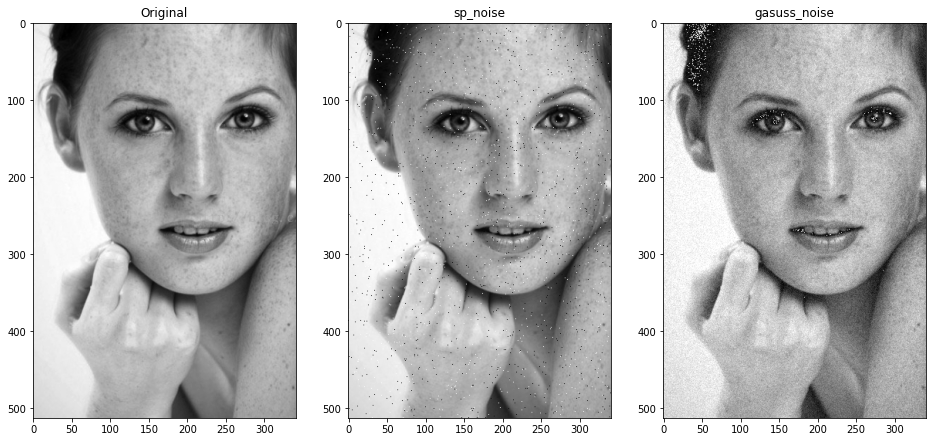

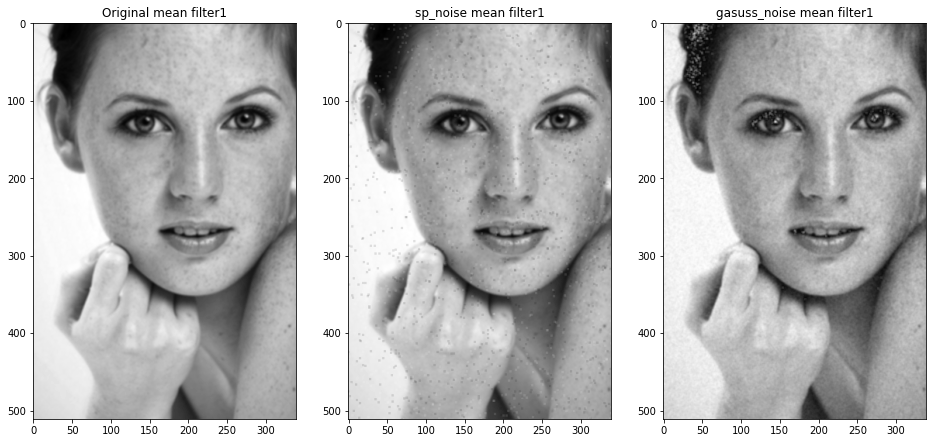

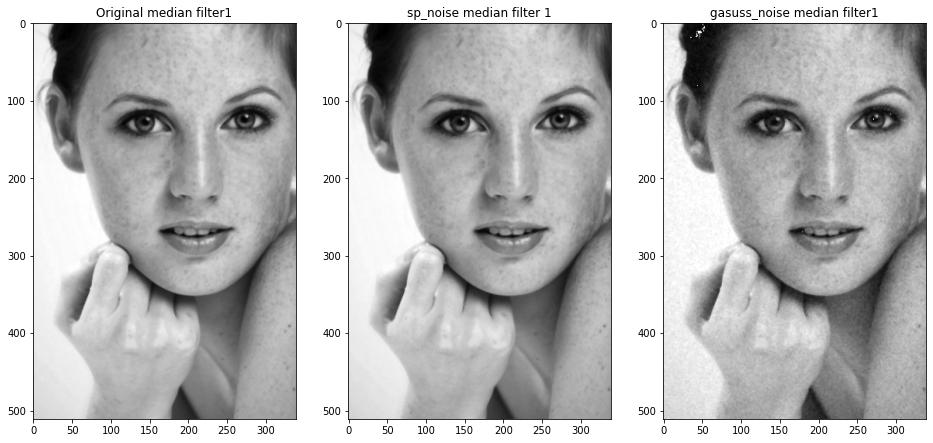

In [9]:
 test(girl, 3, prob=0.005, var=0.005)

从输出可以看出均值滤波对椒盐噪声的滤除效果并不彻底，仍然存在肉眼可见的黑白斑点，而中值滤波能够很好的滤除椒盐噪声。
而对于高斯噪声，观察图片左上角女性的头发处，可以看到中值滤波和均值滤波对高斯噪声的滤除效果都不够彻底。其中均值滤波能够冲淡高斯噪声的灰度值，但噪声分布较广；而中值滤波虽然噪声的灰度值不变，比较突兀，但是噪声的分布范围相对较窄。

 1、 这是因为中值滤波是取每个像素周边区域的中间值来取代该像素点的灰度值，因此其会保留灰度值不变，同时其对孤立的噪声点有很好的滤除效果；均值滤波是对每个像素周边区域取均值来替代像素的灰度值，因此其只能对图像起到平滑作用，如果噪声值与周边像素和的差值过大，均值滤波便不能起到很好的滤波作用。

2、 基于1中的解释，中值滤波对椒盐噪声这种孤立噪声具有非常好的滤波效果，而均值滤波只能平滑图片灰度值，噪点虽然不突兀，但仍然肉眼可见。

3、 同理，对于高斯噪声，中值滤波对于相对滤波器范围孤立的点（在5.2将进一步解释），能够被很好的滤除，而对于密集的噪点只能保留受干扰的灰度值，因此其结果就出现了小范围的突兀噪点，而均值滤波结果仍然只是做到了平滑图像。

4、 由于高斯噪声的每个像素点都或多或少的收到了噪声的干扰，几乎不存在真值像素点，因此中值滤波和均值滤波都不能够彻底地滤除噪声。

#### 5.1.2 Letters

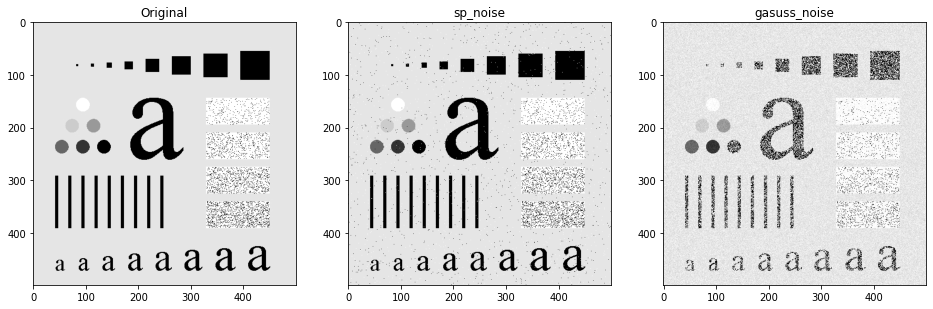

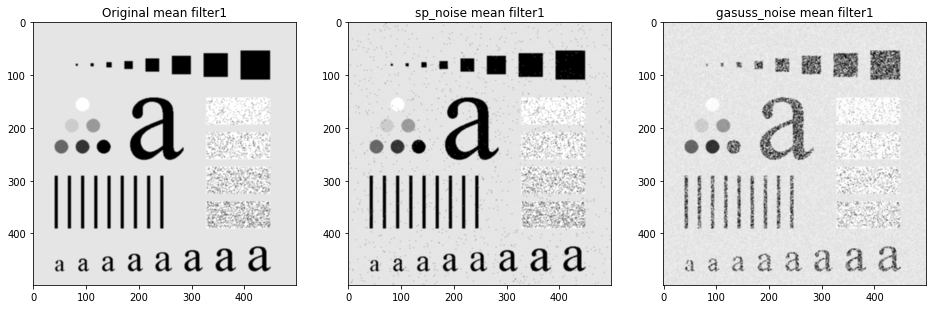

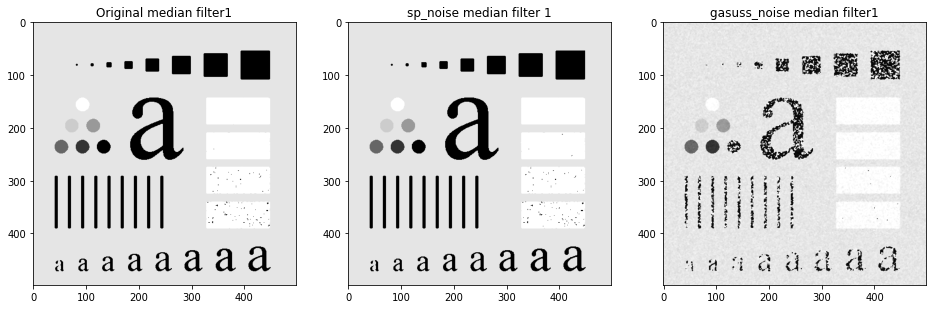

In [10]:
test(Letters, 3, prob=0.005, var=0.005)

与5.1中分析一致，中值滤波对椒盐噪声滤除彻底，其他情况都做不到彻底地滤除。同时，观察结果也能发现，中值滤波器会破坏原图像中存在的孤立像素点，可以看到图片右边的四个点阵，都被严重破坏，并且越稀疏的点阵，破坏越严重，最上面的点阵甚至已经见不到黑点。同时由于高斯噪声减弱了点阵的密度，可以看到高斯噪声的破坏效果比椒盐噪声的更为严重。

#### 5.1.3 lotus

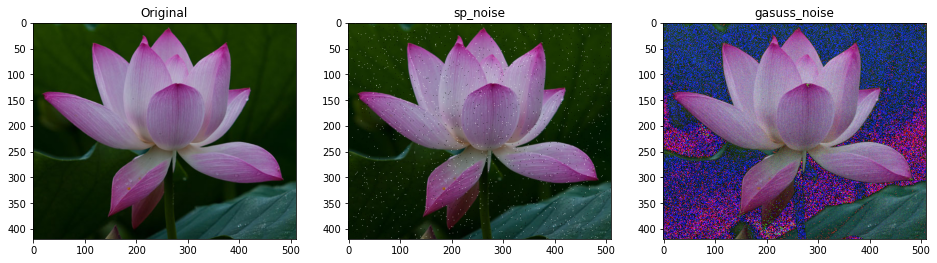

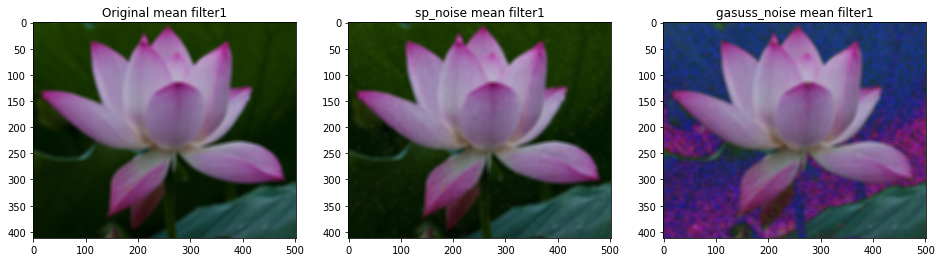

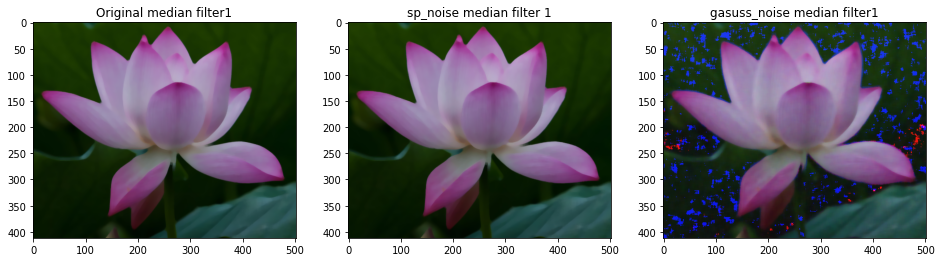

In [11]:
test(lotus, 9, prob=0.005, var=0.0001)

与5.1中一致，中值滤波对高斯噪声的结果图中虽然噪点明显，但范围很小，而均值滤波只起到了平滑的效果，并且中值滤波器能够完全滤除椒盐噪声。

### 5.2 滤波器尺寸

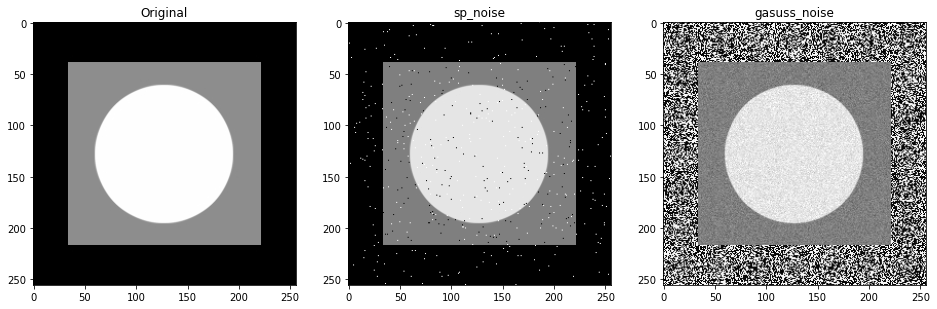

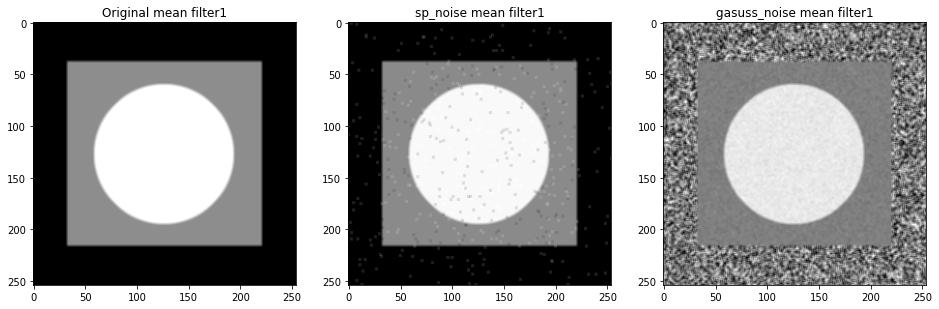

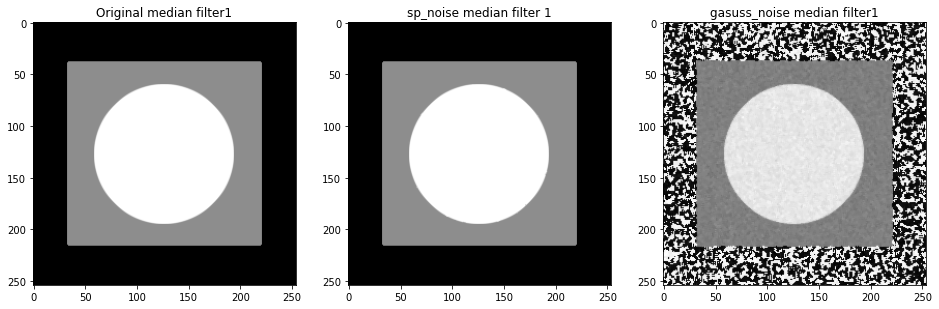

In [12]:
test(pattern, 3, prob=0.005, var=0.0001)

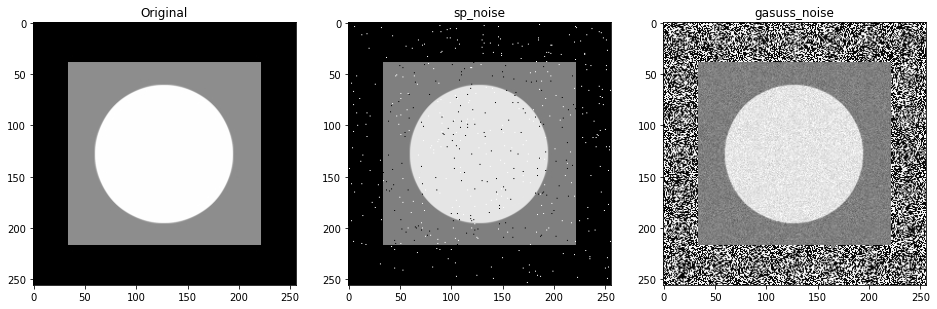

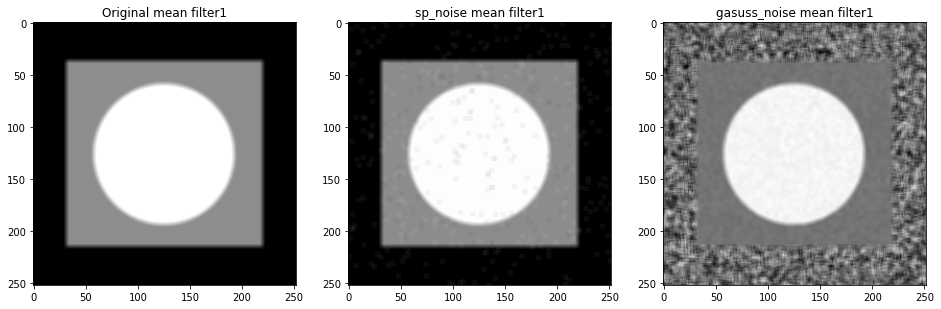

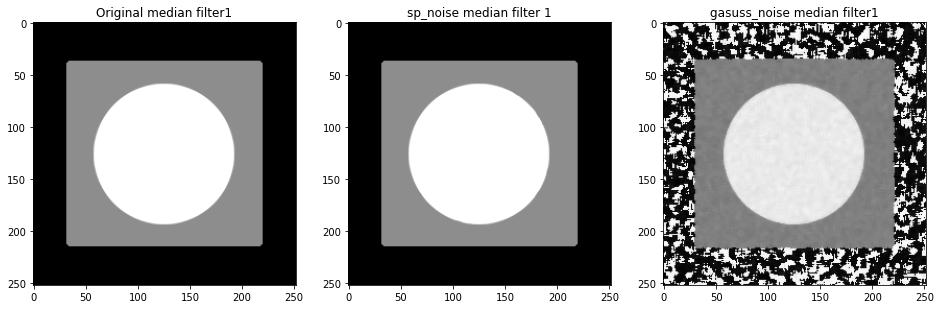

In [13]:
test(pattern, 5, prob=0.005, var=0.0001)

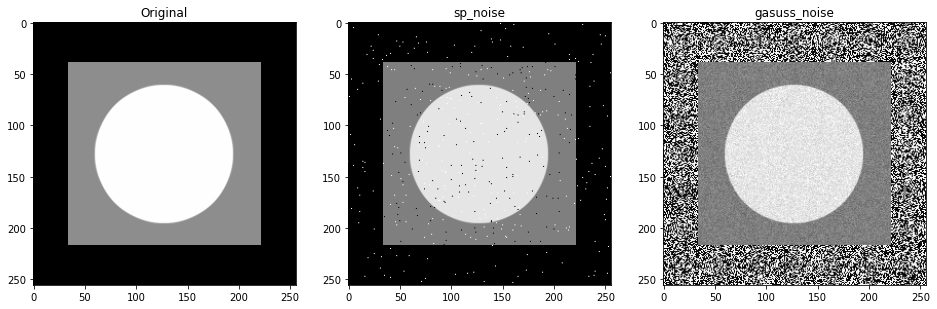

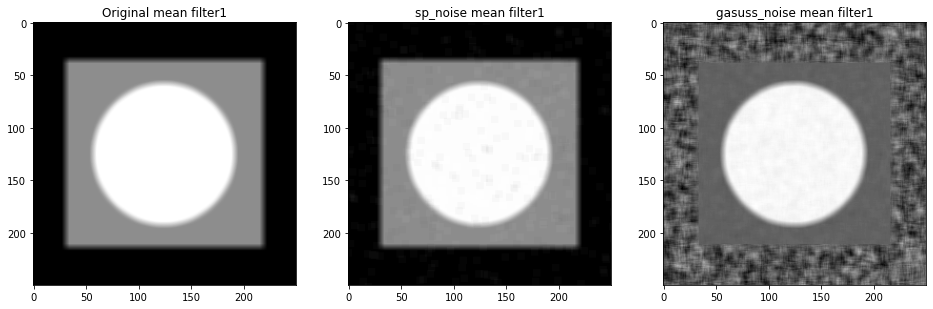

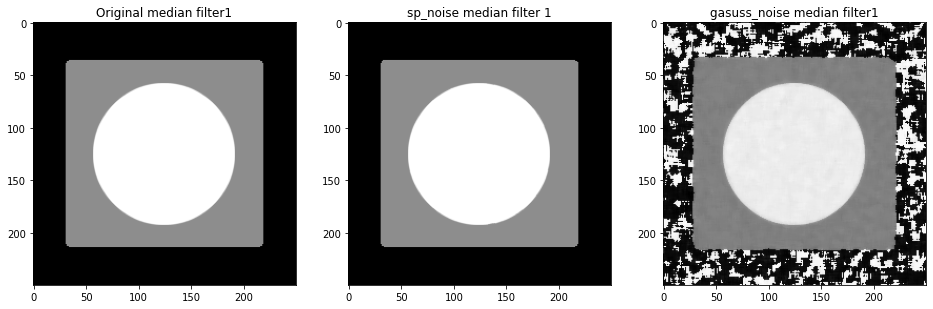

In [14]:
test(pattern, 7, prob=0.005, var=0.0001)

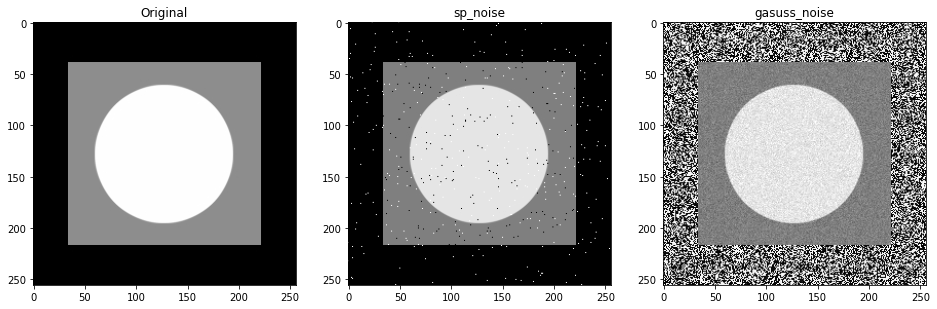

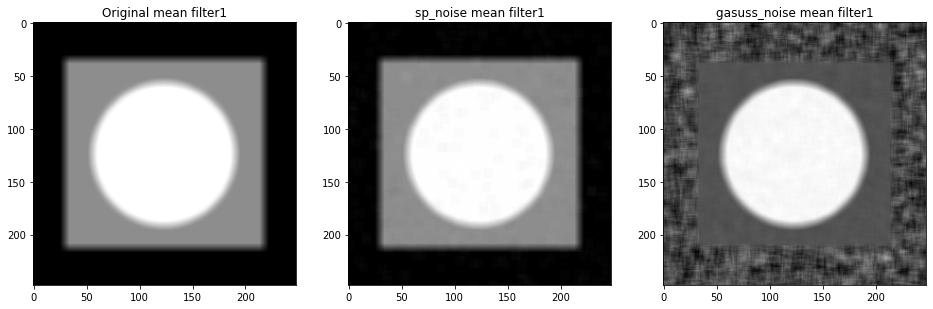

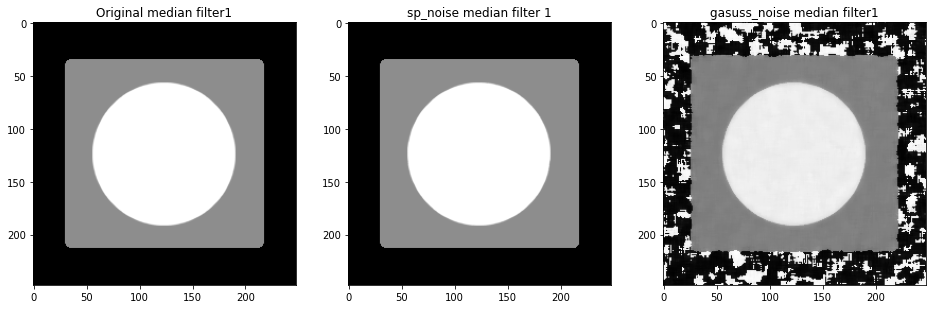

In [15]:
test(pattern, 9, prob=0.005, var=0.0001)

### 5.3 连续滤波

图片尺寸：
(252, 252)
(248, 248)
(244, 244)
(240, 240)
(236, 236)
(232, 232)


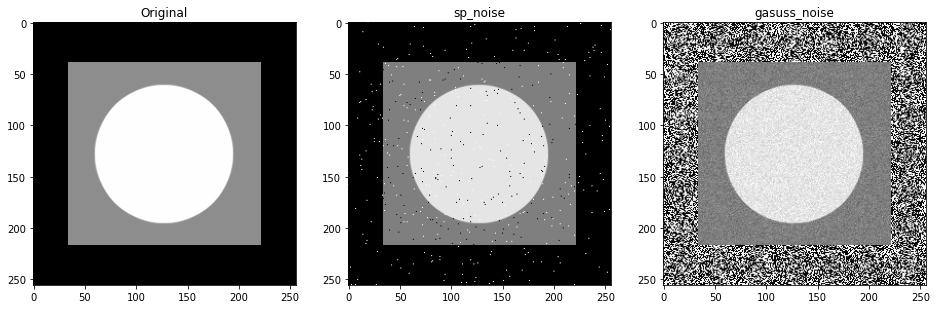

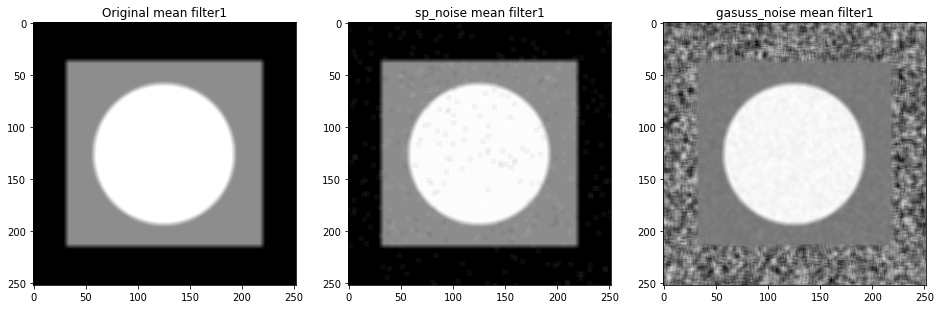

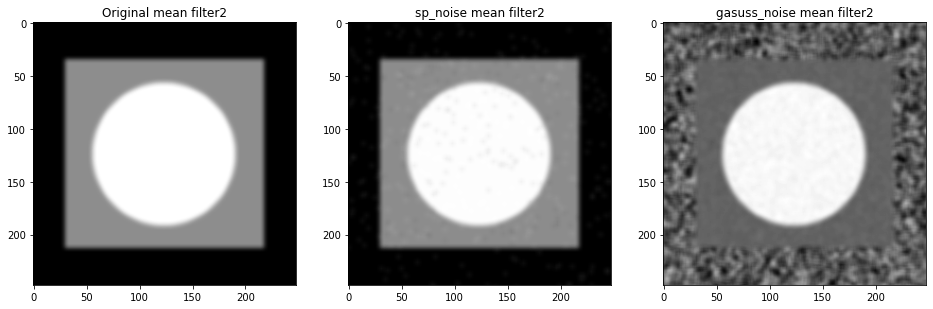

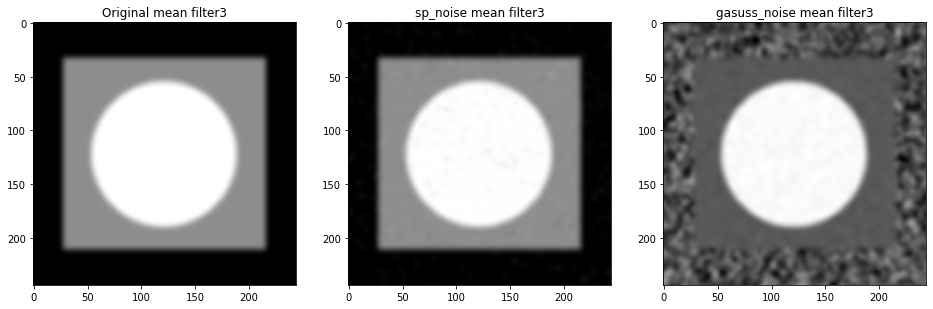

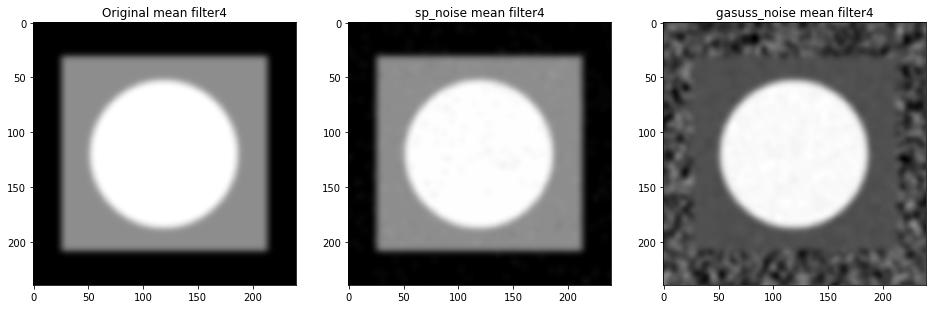

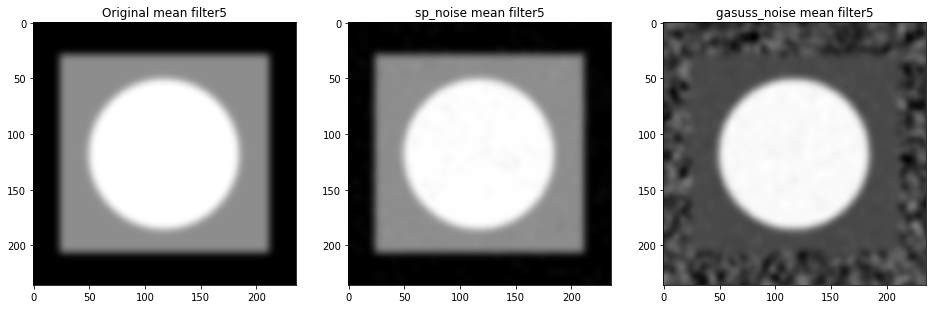

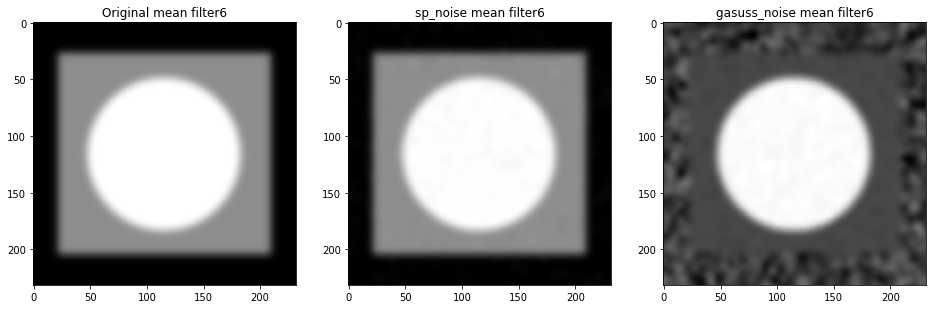

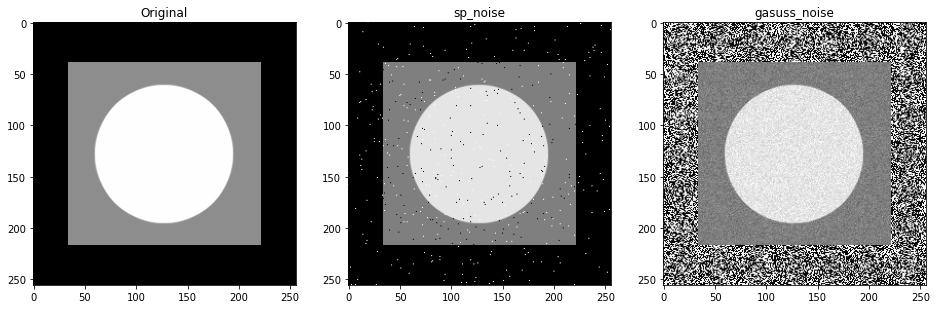

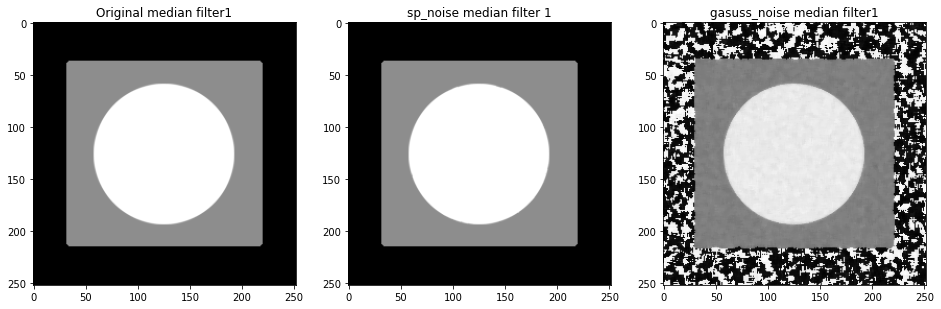

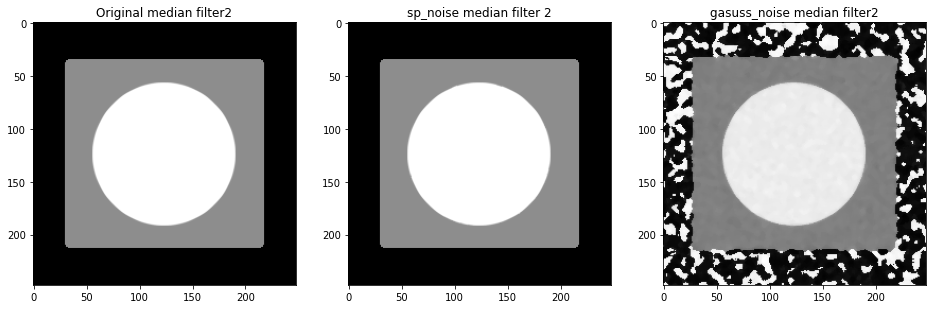

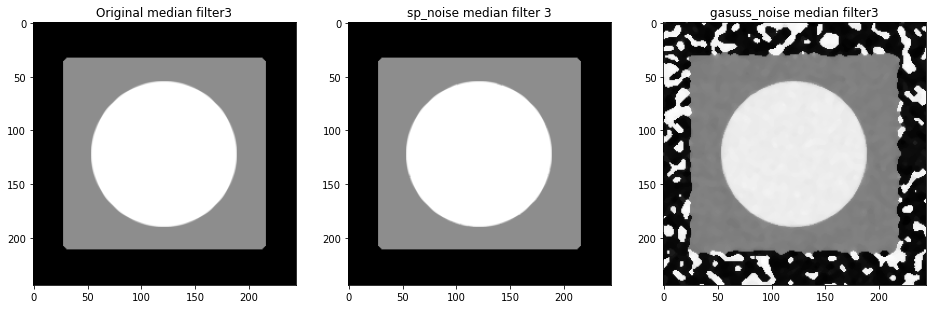

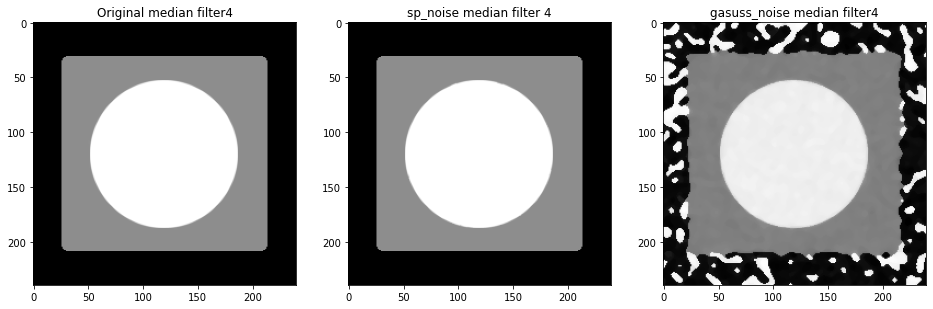

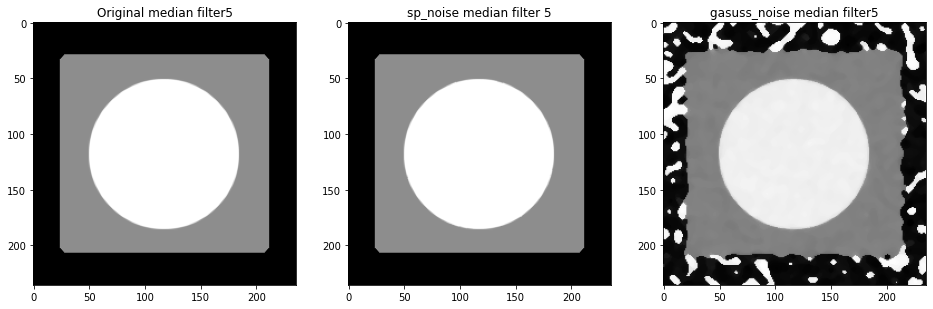

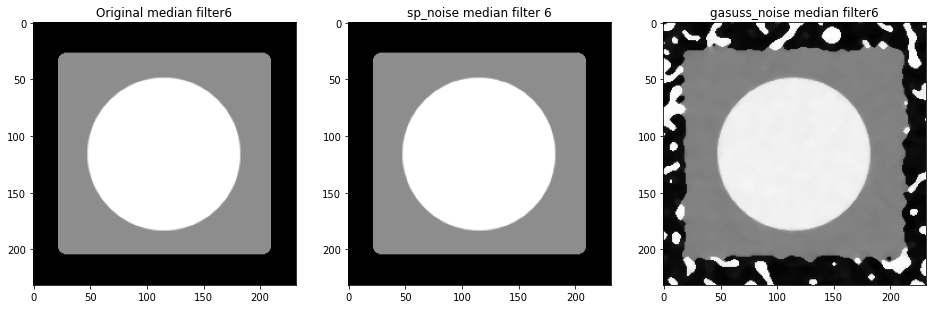

In [16]:
test(pattern, 5, prob=0.005, var=0.0001, times=6)

可以看到，不断地进行滤波，在不做padding的情况下，图片的尺寸越来越小；同时由于越往后运算得出的图片感受野越大，其效果相当于扩大卷积核的大小，与5.2中的结果对比也能证明此结论。可以看到多次均值滤波的效果相当于尺寸大的卷积核，计算出的图片随着次数增加越来越模糊，在第六次时其边缘几乎要消失；同理，多次中值滤波的效果与尺寸大的中值滤波器近似，计算出的图片随着次数的增加圆角越来越明显，在高斯噪声中边缘还被侵蚀。